# **Importing necessary libraries and modules**

In [65]:
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)


# Connecting to the drive to acces the data

In [66]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading the data
The data was preprocessed and stored on the drive for easier accesibility


*   preprocessed_train_data is the data collected for the iperf ran for the duration of 10,20,30,40 Seconds
*   preprocessed_val_data is the data collected for the iperf ran for the duration of 50 Seconds.
*   preprocessed_test_data is the data collected for the iperf ran for the duration of 60 Seconds.
*   preprocessed_train_val_data is a combination of both train and validation sets

In [67]:
DATAPATH = '/content/gdrive/My Drive/Data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
print(train_all_dataset.shape)
print(test_dataset.shape)

(1584, 6)
(392, 6)
(1976, 6)
(391, 6)


# Bringing in new data (more data was collected to increase on the dataset size)

In [68]:
New_data = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_10s.txt')
New_data1 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_20s.txt')
New_data2 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_30s.txt')
New_data3 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_40s.txt')
New_data4 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_50s.txt')
New_data5 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_60s.txt')

# Below are a few data-preprocessing steps to combine old_data with new_data

In [69]:
datasets = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]

In [70]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [71]:
# Operation to only keep the necessary columns / features
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [72]:
# Adding a duration column to the new_data
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df, duration in zip(data_frames, range(10, 70, 10)):
    df['Duration'] = duration
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Transfer': 'Transferred Traffic (KBytes)'}, inplace=True)

In [73]:
# Changing the transffered data into MBytes (for data transffered for 10s)
New_data['Transferred Traffic (KBytes)'] = New_data['Transferred Traffic (KBytes)'] / 1024

In [74]:
# Combining the first 4 new datasets (collected for 10s,20s,30s, and 40s)which will be added to the training_set
combined_New_data = pd.concat([New_data, New_data1, New_data2, New_data3], ignore_index=True)
combined_New_data.reset_index(drop=True, inplace=True)

In [75]:
# Making some spelling correction in the old data
old_data_frames = [train_dataset, val_dataset, test_dataset, train_all_dataset]
for df in old_data_frames:
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Tranfered Trafic (KBytes)': 'Transferred Traffic (KBytes)'}, inplace=True)

In [76]:
# Defining the columns / features to keep in our old dataset
columns_to_keep = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']
train_dataset = train_dataset[columns_to_keep]
val_dataset = val_dataset[columns_to_keep]
test_dataset = test_dataset[columns_to_keep]

In [77]:
# Combining the old dataset with the new dataset
New_train_data = pd.concat([train_dataset, combined_New_data], ignore_index=True)
New_val_data = pd.concat([val_dataset, New_data4], ignore_index=True)
New_test_data = pd.concat([test_dataset, New_data5], ignore_index=True)

In [78]:
# Selecting out data to make re-arrangements in it
df_10 = New_train_data[New_train_data['Duration'] == 10]
df_20 = New_train_data[New_train_data['Duration'] == 20]
df_30 = New_train_data[New_train_data['Duration'] == 30]
df_40 = New_train_data[New_train_data['Duration'] == 40]

In [79]:
# combining the new_train data in the right order
train_data_final = pd.concat([df_10, df_20, df_30, df_40], ignore_index=True)

In [80]:
# combining the new_train data with the validation_data to make a big richer set (train_data_final_all)
train_data_final_all = pd.concat([train_data_final, New_val_data], ignore_index=True)

In [81]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transffered Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(feature_matrix(train_data_final,features),dtype=np.float32)
train_labels = np.asarray(train_data_final['Transferred Traffic (KBytes)'],dtype=np.float32)

val_values = np.asarray(feature_matrix(New_val_data,features),dtype=np.float32)
val_labels = np.asarray(New_val_data['Transferred Traffic (KBytes)'],dtype=np.float32)

# data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_data_final_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_data_final_all['Transferred Traffic (KBytes)'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(New_test_data,features),dtype=np.float32)
test_labels = np.asarray(New_test_data['Transferred Traffic (KBytes)'],dtype=np.float32)



# checking out the data
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)



(4701, 3)
(4701,)
(1172, 3)
(1172,)
(5873, 3)
(5873,)
(1171, 3)
(1171,)


In [82]:
# Scaling the data to the right format for our model
from sklearn.preprocessing import StandardScaler
SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)


SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

# Setting the desired WINDOW_SIZE

In [83]:
WINDOW_SIZE = 10

In [84]:
# window-based and recurrent networks:
# making predictions seconds ahead. NB: 8 = 4seconds ....
# for now the window size is set to WINDOW_SIZE

def create_dataset_windowed(features, labels, ahead=8, window_size=WINDOW_SIZE, max_window_size=50):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]



## Creating the windowed dataset from training and validation data

In [85]:
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels)

In [86]:
# setting some regularization parameters
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [87]:
from keras.callbacks import LearningRateScheduler
def create_model(input_shape):

    # Initializing the Sequential model
    model = Sequential()

    # Adding layers to the model
    model.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    # Compiling the model
    model.compile(optimizer=Nadam(lr=0.0001), loss='mae')

    # Returning the model
    return model

# Fitting the model

In [88]:
LSTM_model = create_model((WINDOW_SIZE,3))
LSTM_history = LSTM_model.fit(X_train_w, r_train_w, epochs=40, batch_size=64, validation_data=(X_val_w, r_val_w))

Epoch 1/40
73/73 [==============================] - 18s 53ms/step - loss: 68.8571 - val_loss: 33.9188
Epoch 2/40
73/73 [==============================] - 2s 23ms/step - loss: 20.6298 - val_loss: 12.8546
Epoch 3/40
73/73 [==============================] - 2s 23ms/step - loss: 8.9082 - val_loss: 6.7555
Epoch 4/40
73/73 [==============================] - 2s 29ms/step - loss: 5.0402 - val_loss: 4.8485
Epoch 5/40
73/73 [==============================] - 2s 28ms/step - loss: 3.4330 - val_loss: 3.6066
Epoch 6/40
73/73 [==============================] - 2s 22ms/step - loss: 2.6735 - val_loss: 3.4439
Epoch 7/40
73/73 [==============================] - 2s 22ms/step - loss: 2.1953 - val_loss: 3.0210
Epoch 8/40
73/73 [==============================] - 2s 22ms/step - loss: 1.8094 - val_loss: 2.5591
Epoch 9/40
73/73 [==============================] - 2s 23ms/step - loss: 1.5125 - val_loss: 2.2910
Epoch 10/40
73/73 [==============================] - 2s 24ms/step - loss: 1.2019 - val_loss: 2.3959
Epoc

# Plotting the training and validation loss curves

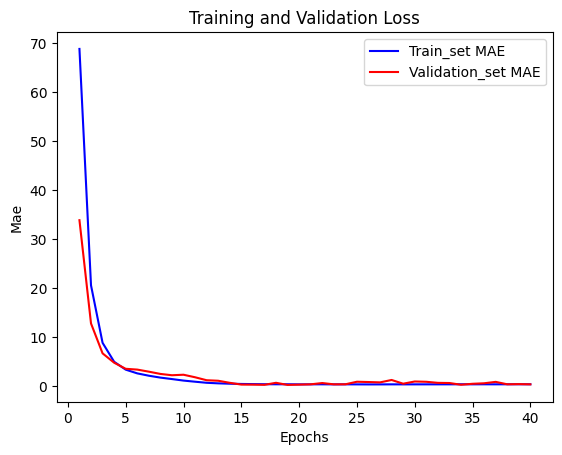

In [89]:
train_loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train_set MAE')
plt.plot(epochs, val_loss, 'r', label='Validation_set MAE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

# Obtaining the average Mean Absolute Error on training and validation

35/35 [==============================] - 0s 5ms/step
"Current Network throuput
 train mae =  0.2588001 
 validation mae =  0.12998219
(4644, 1)
(1115, 1)


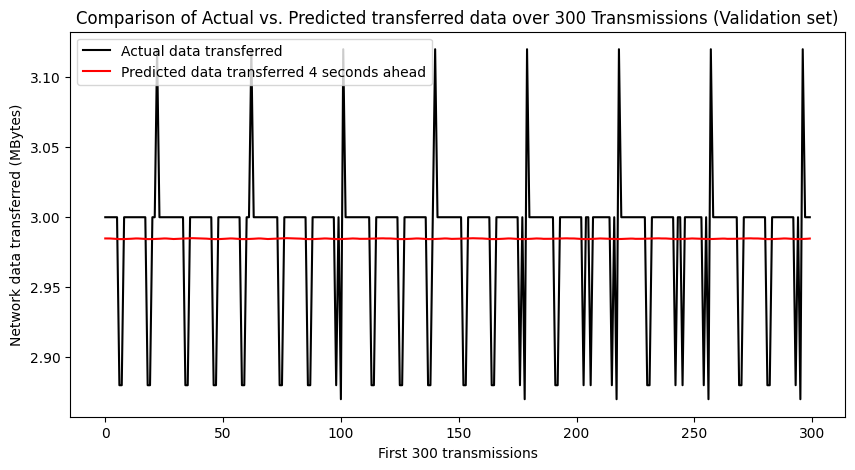

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Making predictions using the trained model
y_train_LSTM = LSTM_model.predict(X_train_w)
y_val_LSTM = LSTM_model.predict(X_val_w)

# Calculating the mean absolute error from the training and validation sets
mae_train_LSTM = mean_absolute_error(r_train_w, y_train_LSTM)
mae_val_LSTM = mean_absolute_error(r_val_w, y_val_LSTM)

# Printing the mean absolute error from the training and validation sets
print("\"Current Network throuput\n train mae = ", mae_train_LSTM,
      "\n validation mae = ", mae_val_LSTM)

# Printing the shapes of the predicted output from the training and val sets
print(y_train_LSTM.shape)
print(y_val_LSTM.shape)

# Visualising first 300 predictions from the validation set

def scale_predictions_to_labels(labels, predictions):
    scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions * scale_factor
    return scaled_predictions

# Applying the scaling function
scaled_predictions = scale_predictions_to_labels(r_val_w[:300], y_val_LSTM[:300, 0])

# Now plotting the labels and scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(r_val_w[:300], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:300], 'r-', label='Predicted data transferred 4 seconds ahead')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 300 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 300 Transmissions (Validation set)')  # Adding a title for context
plt.legend()
plt.show()

# Evaluating the model performance on the test_set this time combining the training and validation set to form a richer (train_all dataset) which is a bigger dataset




In [91]:
# Creating the windowed dataset
X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels)

print(X_train_all_w.shape)
print(r_train_all_w.shape)
print(X_test_w.shape)
print(r_test_w.shape)

(5816, 10, 3)
(5816,)
(1114, 10, 3)
(1114,)


In [92]:
# applying some regularization as before
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [93]:
from keras.callbacks import LearningRateScheduler
def create_model_test(input_shape):

    # Initializing the Sequential model
    model = Sequential()
    # Adding layers to the model
    model.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    # Compiling the model
    model.compile(optimizer=Nadam(lr=0.00001), loss='mae')

    # Returning the model
    return model

# Fitting the model

In [94]:
LSTM_model_test = create_model_test((WINDOW_SIZE,3))
LSTM_model_test.summary()
LSTM_history_test = LSTM_model_test.fit(X_train_all_w, r_train_all_w, epochs=40, batch_size=64, validation_data=(X_test_w, r_test_w))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirect  (None, 10, 1024)          2113536   
 ional)                                                          
                                                                 
 batch_normalization_20 (Ba  (None, 10, 1024)          4096      
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 10, 1024)          0         
                                                                 
 bidirectional_16 (Bidirect  (None, 10, 512)           2623488   
 ional)                                                          
                                                                 
 batch_normalization_21 (Ba  (None, 10, 512)           2048      
 tchNormalization)                                    

# Plotting the training and testing loss curves

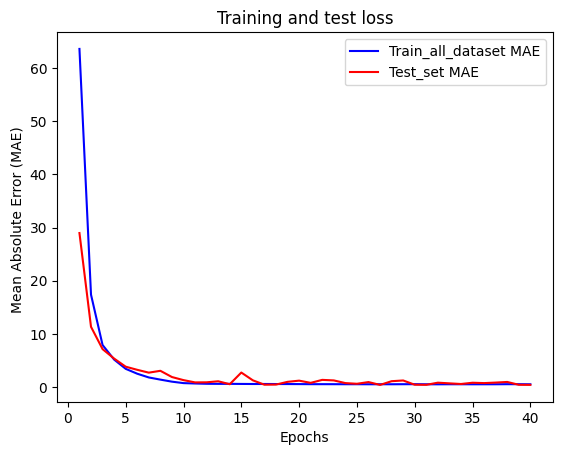

In [95]:
train_all_loss = LSTM_history_test.history['loss']
test_loss = LSTM_history_test.history['val_loss']

# Plotting the training and test loss
epochs = range(1, len(train_all_loss) + 1)
plt.plot(epochs, train_all_loss, 'b', label='Train_all_dataset MAE')
plt.plot(epochs, test_loss, 'r', label='Test_set MAE')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE) ')
plt.legend()
plt.show()

# Obtaining the average Mean Absolute Error on training and testing

35/35 [==============================] - 0s 7ms/step
"Current Network throuput
 train mae =  0.28086087 
 validation mae =  0.05337534
(5816, 1)
(1114, 1)


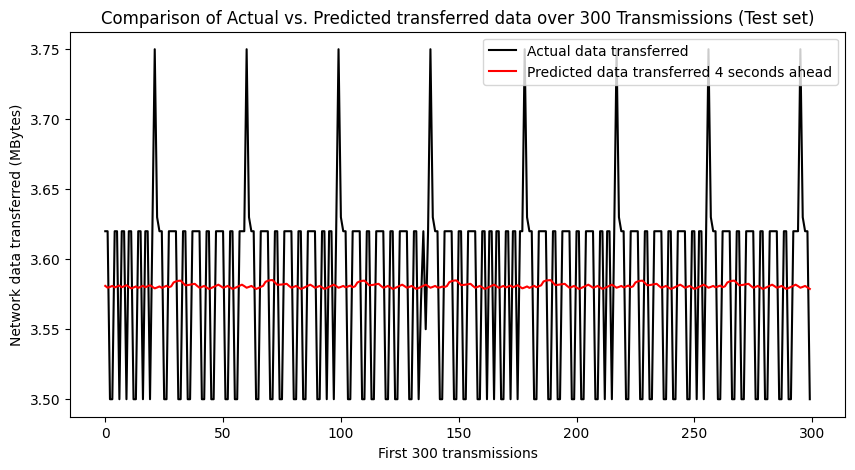

In [96]:
# Making predictions using the trained model
y_train_all_LSTM = LSTM_model_test.predict(X_train_all_w)
y_test_LSTM = LSTM_model_test.predict(X_test_w)

# Calculating the mean absolute error from the training and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_w, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_w, y_test_LSTM)

# Printing the mean absolute error from the training and test sets
print("\"Current Network throuput\n train mae = ", mae_train_all_LSTM,
      "\n validation mae = ", mae_test_LSTM)

# Printing the shapes of the predicted output from the training and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

# Visualising first 300 predictions from the test set

def scale_predictions_to_labels(labels, predictions):
    scale_factor = np.mean(labels) / np.mean(predictions)
    scaled_predictions = predictions * scale_factor
    return scaled_predictions

# Applying the scaling function
scaled_predictions = scale_predictions_to_labels(r_test_w[:300], y_test_LSTM[:300, 0])

# Now plotting the labels and predictions
plt.figure(figsize=(10, 5))
plt.plot(r_test_w[:300], 'k-', label='Actual data transferred')
plt.plot(scaled_predictions[:300], 'r-', label='Predicted data transferred 4 seconds ahead')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 300 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 300 Transmissions (Test set)')  # Adding a title for context
plt.legend()
plt.show()